In [1]:
# Installing necessary packages
!pip install yfinance scikit-learn matplotlib keras tensorflow pandas numpy seaborn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Basic libraries for data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# For downloading stock data
import yfinance as yf

In [4]:
# For scaling, splitting, and evaluating models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [5]:
# Traditional ML models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [6]:
# Deep learning model (LSTM)
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout

In [7]:
# Download AAPL stock data
df = yf.download('AAPL', start='2010-01-01', end='2023-12-31', auto_adjust=True)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.431897,6.446623,6.382908,6.414465,493729600
2010-01-05,6.443016,6.479381,6.409054,6.449628,601904800
2010-01-06,6.340531,6.468562,6.333919,6.443016,552160000
2010-01-07,6.328811,6.371489,6.282828,6.363975,477131200
2010-01-08,6.370886,6.371488,6.283129,6.320395,447610800


In [8]:
# Add MA10 and RSI indicators
df['MA10'] = df['Close'].rolling(window=10).mean()
df['RSI'] = 100 - (100 / (1 + df['Close'].pct_change().rolling(14).mean()))
df.dropna(inplace=True)
df.head()

Price,Close,High,Low,Open,Volume,MA10,RSI
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,
2010-01-25,6.103102,6.152090,6.016546,6.086271,1065699600,6.249768,-0.352015
2010-01-26,6.189359,6.422880,6.088377,6.189660,1867110000,6.237235,-0.262864
2010-01-27,6.247665,6.328811,5.996712,6.216709,1722568400,6.237716,-0.081337
2010-01-28,5.989498,6.176135,5.971767,6.159004,1173502400,6.203575,-0.364550
2010-01-29,5.772207,6.076957,5.717809,6.043296,1245952400,6.151370,-0.674363


In [9]:
# Create target: 1 if next day's close > today
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df.head()

Price,Close,High,Low,Open,Volume,MA10,RSI,Target
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,
Date,,,,,,,,
2010-01-25,6.103102,6.152090,6.016546,6.086271,1065699600,6.249768,-0.352015,1
2010-01-26,6.189359,6.422880,6.088377,6.189660,1867110000,6.237235,-0.262864,1
2010-01-27,6.247665,6.328811,5.996712,6.216709,1722568400,6.237716,-0.081337,0
2010-01-28,5.989498,6.176135,5.971767,6.159004,1173502400,6.203575,-0.364550,0
2010-01-29,5.772207,6.076957,5.717809,6.043296,1245952400,6.151370,-0.674363,1


In [10]:
# Select and scale features
features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MA10', 'RSI']]
target   = df['Target']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(features)
y = target.values

In [11]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [12]:
# Fit and evaluate SVM, Decision Tree, Random Forest, Logistic Regression
models = {
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))
    
    print(f"\n--- {name} ---")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

dt_model = models['Decision Tree']      
print("Chosen model: Decision Tree")


--- SVM ---
Accuracy: 0.49715099715099714
              precision    recall  f1-score   support

           0       0.48      0.84      0.61       333
           1       0.56      0.19      0.28       369

    accuracy                           0.50       702
   macro avg       0.52      0.51      0.45       702
weighted avg       0.53      0.50      0.44       702


--- Decision Tree ---
Accuracy: 0.5056980056980057
              precision    recall  f1-score   support

           0       0.47      0.34      0.40       333
           1       0.52      0.65      0.58       369

    accuracy                           0.51       702
   macro avg       0.50      0.50      0.49       702
weighted avg       0.50      0.51      0.49       702


--- Random Forest ---
Accuracy: 0.4658119658119658
              precision    recall  f1-score   support

           0       0.47      0.87      0.61       333
           1       0.46      0.10      0.17       369

    accuracy                       

In [13]:
# Reshape input for LSTM
X_lstm = np.reshape(X, (X.shape[0], 1, X.shape[1]))
X_train_lstm = X_lstm[:int(0.8*len(X_lstm))]
X_test_lstm = X_lstm[int(0.8*len(X_lstm)):]
y_train_lstm = y[:int(0.8*len(y))]
y_test_lstm = y[int(0.8*len(y)):]

In [14]:
# LSTM architecture
lstm_model = Sequential()
lstm_model.add(Input(shape=(1, X.shape[1])))
lstm_model.add(LSTM(100, return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5207 - loss: 0.6923
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5502 - loss: 0.6888
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5322 - loss: 0.6901
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5217 - loss: 0.6913
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5305 - loss: 0.6919
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5292 - loss: 0.6911
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5263 - loss: 0.6891
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5138 - loss: 0.6932
Epoch 9/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5248 - loss: 0.6908
Epoch 10/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5278 - loss: 0.6909


In [15]:
# Evaluate LSTM predictions
lstm_pred = lstm_model.predict(X_test_lstm)
lstm_pred = (lstm_pred > 0.5).astype(int)

lstm_acc = accuracy_score(y_test_lstm, lstm_pred)
results.append(("LSTM", lstm_acc))

print("\n--- LSTM Model ---")
print("Accuracy:", lstm_acc)
print(classification_report(y_test_lstm, lstm_pred))

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step

--- LSTM Model ---
Accuracy: 0.4985754985754986
              precision    recall  f1-score   support

           0       0.48      0.68      0.56       333
           1       0.54      0.33      0.41       369

    accuracy                           0.50       702
   macro avg       0.51      0.51      0.49       702
weighted avg       0.51      0.50      0.48       702



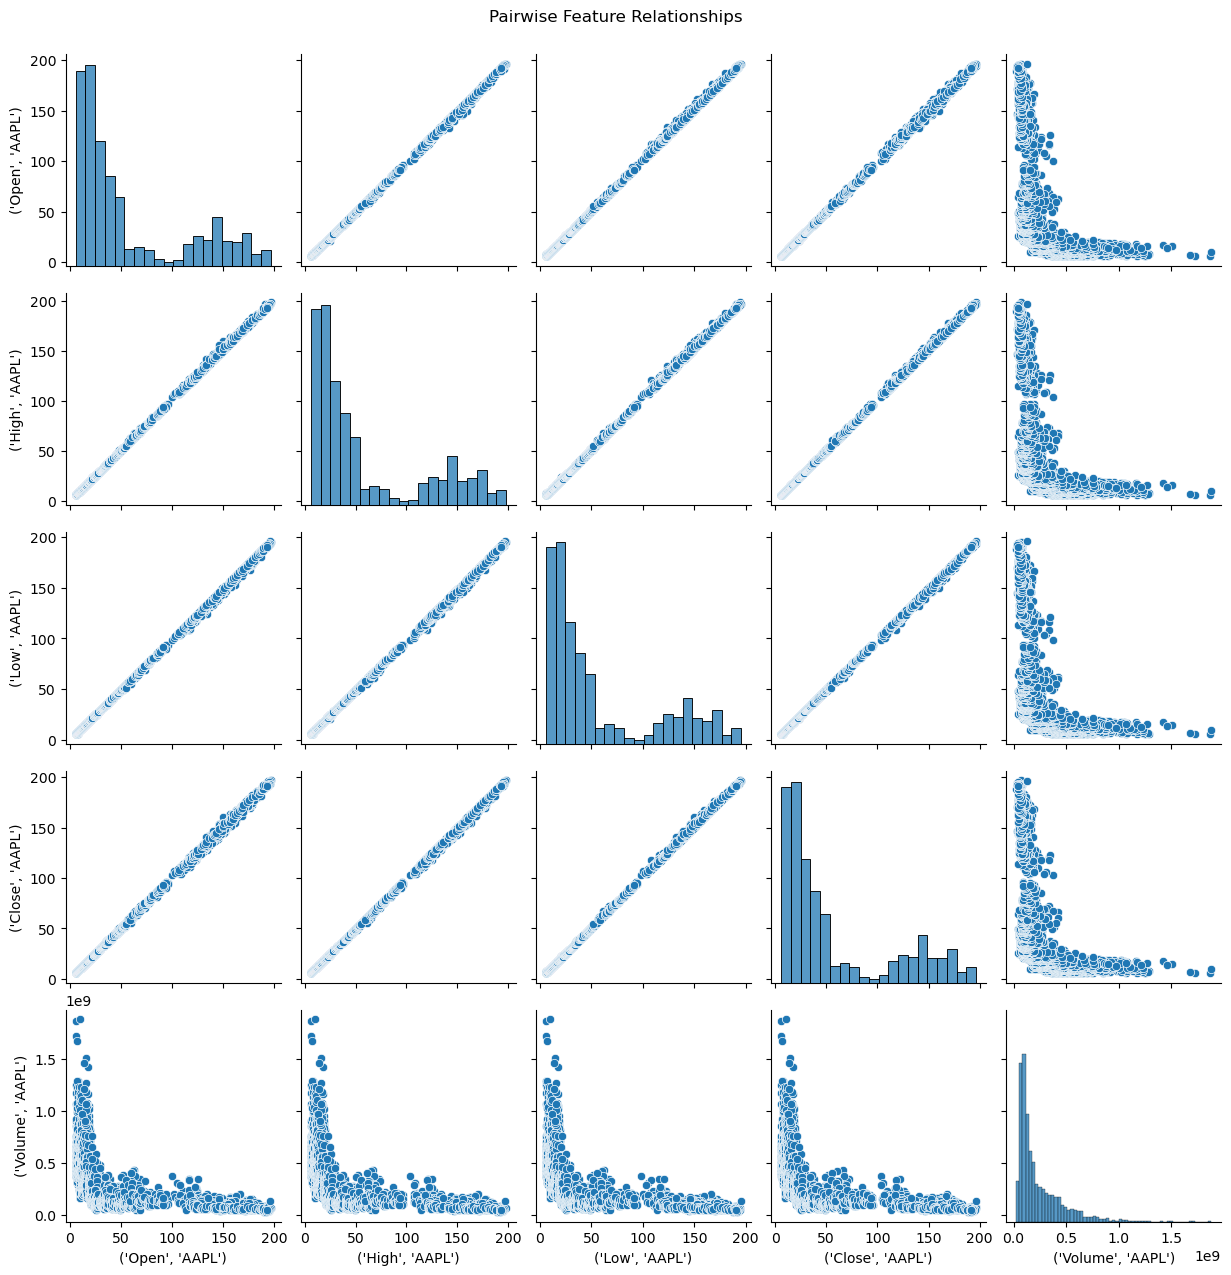

In [16]:
# Pairplot for features
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

sns.pairplot(df[feature_columns])
plt.suptitle('Pairwise Feature Relationships', y=1.02)
plt.show()

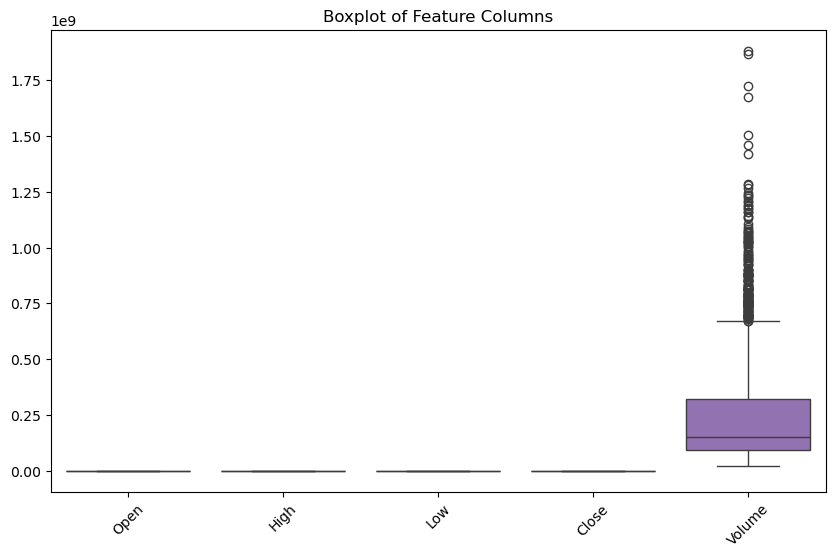

In [17]:
# Boxplot to detect outliers
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.figure(figsize=(10, 6))
sns.boxplot(data=df[feature_columns])
plt.xticks(rotation=45)
plt.title('Boxplot of Feature Columns')
plt.show()

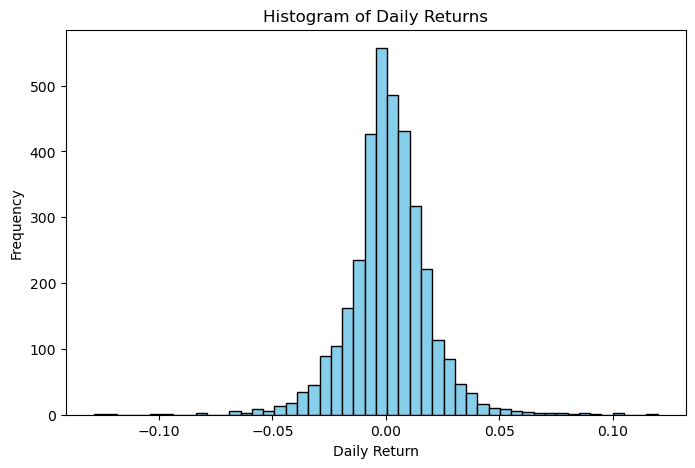

In [18]:
# Histogram of daily returns or any continuous feature
if 'Daily Return' not in df.columns:
    df['Daily Return'] = df['Close'].pct_change()
plt.figure(figsize=(8, 5))
plt.hist(df['Daily Return'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

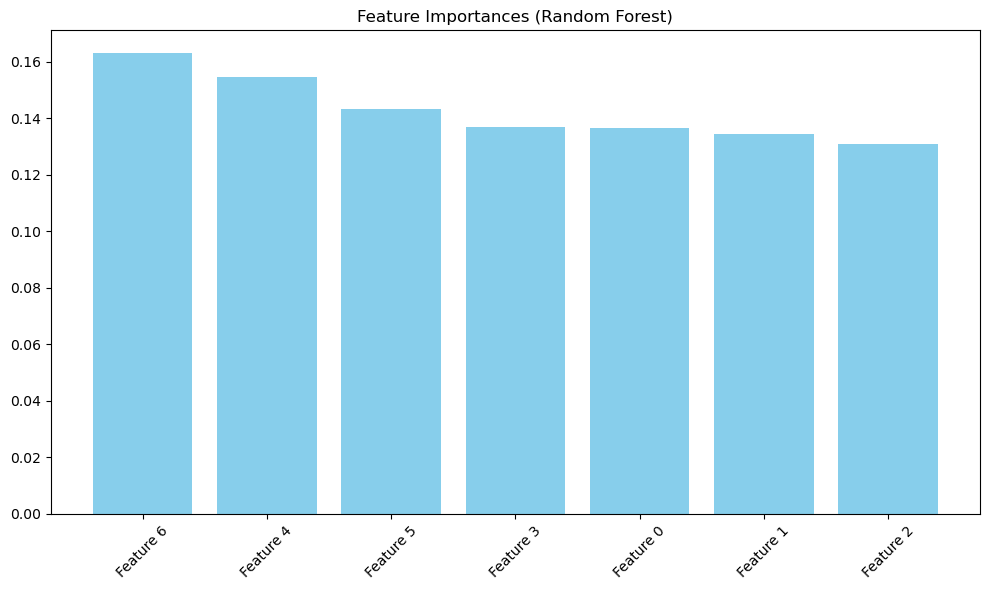

In [19]:
# Plot feature importance
feature_columns = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

rf_model = models['Random Forest']

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(importances)), importances[indices], color='skyblue', align='center')
plt.xticks(range(len(importances)), [feature_columns[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

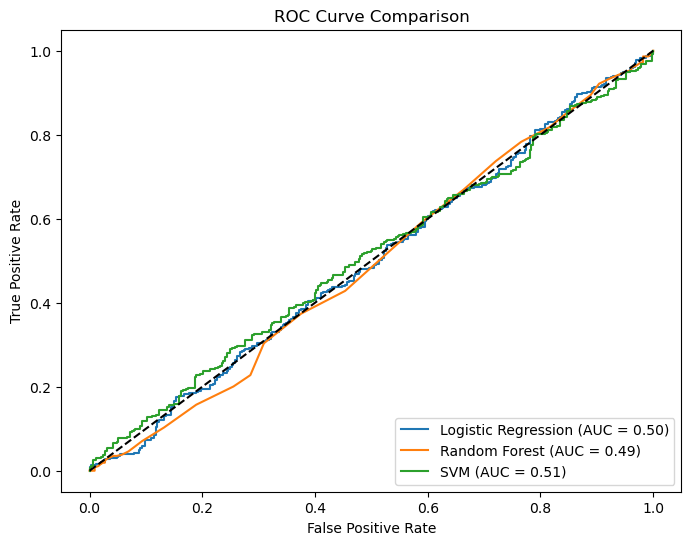

In [20]:
# ROC Curve plotting for classifiers
from sklearn.metrics import roc_curve, auc

def plot_roc(model, X_test, y_test, label='Model'):
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        raise ValueError("Model doesn't support ROC curve plotting")
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

logreg_model = models['Logistic Regression']
rf_model = models['Random Forest']
svm_model = models['SVM']

plt.figure(figsize=(8, 6))
plot_roc(logreg_model, X_test, y_test, label='Logistic Regression')
plot_roc(rf_model, X_test, y_test, label='Random Forest')
plot_roc(svm_model, X_test, y_test, label='SVM')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5389 - loss: 0.6946 - val_accuracy: 0.4744 - val_loss: 0.7310
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5061 - loss: 0.6946 - val_accuracy: 0.4744 - val_loss: 0.7183
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5404 - loss: 0.6923 - val_accuracy: 0.4744 - val_loss: 0.7046
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5409 - loss: 0.6903 - val_accuracy: 0.5256 - val_loss: 0.7188
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5418 - loss: 0.6897 - val_accuracy: 0.5242 - val_loss: 0.6921
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5552 - loss: 0.6884 - val_accuracy: 0.5256 - val_loss: 0.6983
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5409 - loss: 0.6890 - val_accuracy: 0.4758 - val_loss: 0.6973
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5495 - loss: 0.6889 - val_accuracy: 0.4744 - val_loss

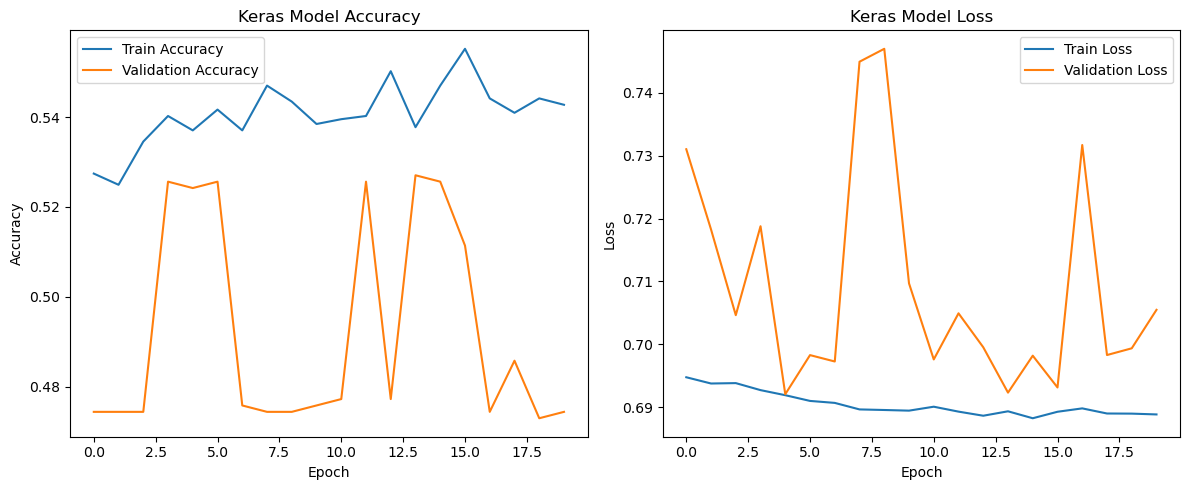

In [21]:
# Keras Model Accuracy and Loss over Epochs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

keras_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

keras_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

history = keras_model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_test_scaled, y_test_cat),
    epochs=20,
    batch_size=32,
    verbose=1
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Keras Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Keras Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

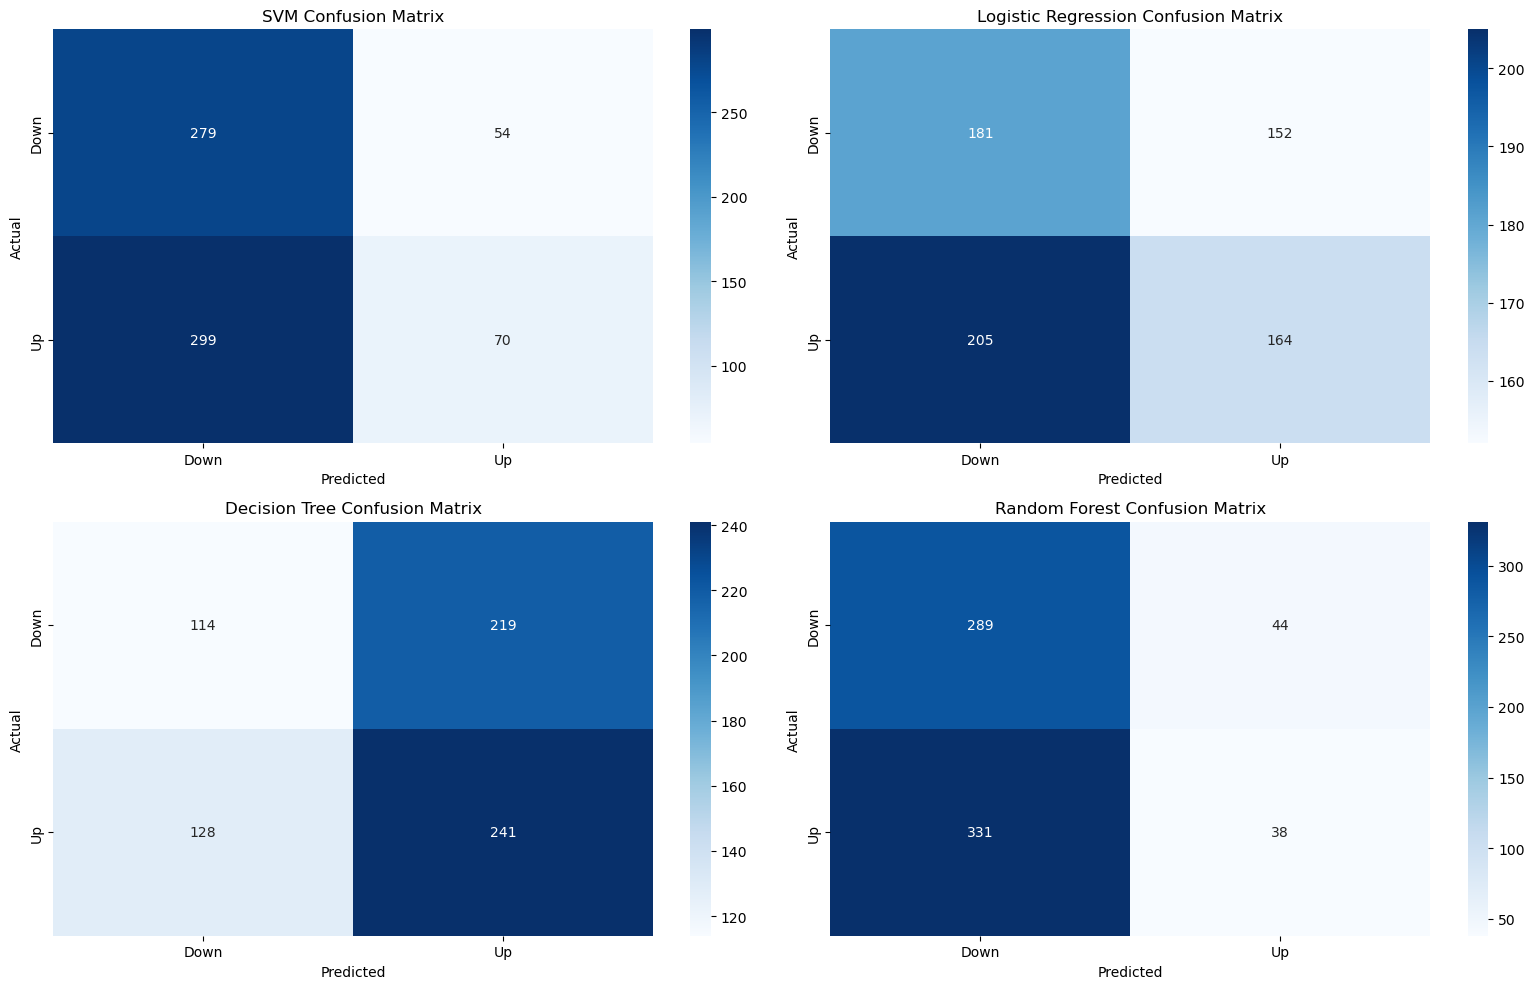

In [22]:
# COnfusion Matrices for all Classifier Models
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model_names = ['SVM', 'Logistic Regression', 'Decision Tree', 'Random Forest']

plt.figure(figsize=(16, 10))
for i, name in enumerate(model_names, 1):
    model = models[name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.subplot(2, 2, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

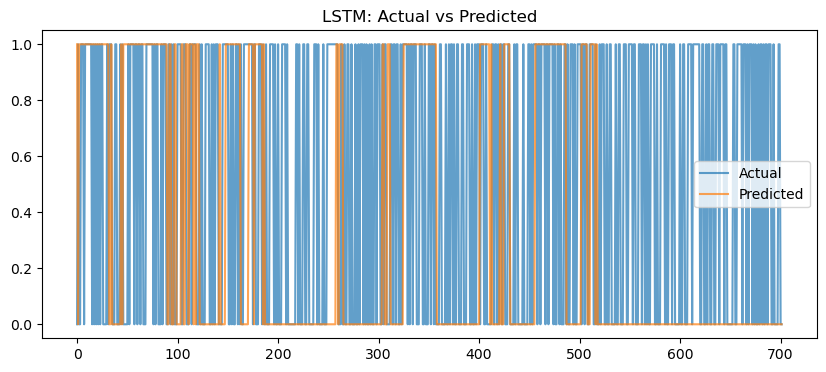

In [23]:
# Compare actual vs predicted
plt.figure(figsize=(10,4))
plt.plot(y_test_lstm, label='Actual', alpha=0.7)
plt.plot(lstm_pred, label='Predicted', alpha=0.7)
plt.title("LSTM: Actual vs Predicted")
plt.legend()
plt.show()

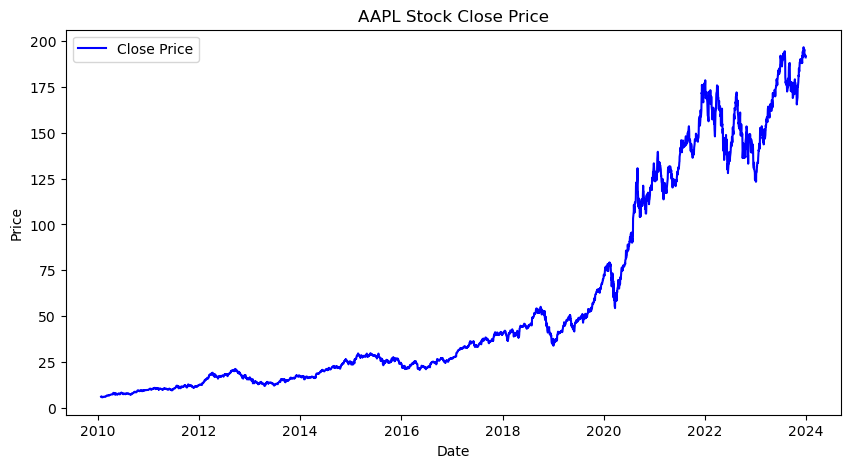

In [24]:
# Plot AAPL close price over time
plt.figure(figsize=(10,5))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title("AAPL Stock Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [25]:
# Compare accuracy of all models
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy'])
results_df.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
1,Decision Tree,0.505698
4,LSTM,0.498575
0,SVM,0.497151
3,Logistic Regression,0.491453
2,Random Forest,0.465812


In [26]:
# Picking the model we actually want to keep
rf_model = models['Random Forest']      
best_name, best_acc = max(results, key=lambda x: x[1])
best_model = models[best_name]
print(f"Chosen best model: {best_name} (accuracy = {best_acc:.3f})")

Chosen best model: Decision Tree (accuracy = 0.506)


In [27]:
import joblib

joblib.dump(dt_model, "decision_tree.joblib")
joblib.dump(scaler, "scaler.joblib")

print("✅ Exported Decision Tree model and scaler")

✅ Exported Decision Tree model and scaler
